## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# <center>Tópicos selectos de ciencia de datos<center>
# <center>Proyecto final<center>
## <center>CNN para análisis de sentimientos en textos en español<center>

In [1]:
CurrentPath='/content/drive/MyDrive/Colab Notebooks/ProyectoCiencia/Sentiment/Spanish'

In [2]:
#librerias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dataset

In [3]:
#lee los datos
df=pd.read_csv(CurrentPath+'/train.csv',index_col=0)
df.head()

,tweets,polarity
0,@FridaCoral ven a chetu mejor,NEU
1,quiero y necesito verte yaaaa,P
2,Danniel es como mi amor frustrado,N
3,Solo a los fav responde celosa mil @belindapop...,N
4,@belindapop #AskBeli ¿Porque siempre respondes...,NEU


In [7]:
df.polarity.value_counts()/len(df) #% de cada clase

N      0.333333
P      0.333333
NEU    0.333333
Name: polarity, dtype: float64

In [4]:
TEXTS=df.tweets.values
labels=df.polarity.values

pre proceso:
- minusculas
- quita acentos, duplicados
- reemplaza: #, numeros, emojis, url, @

In [ ]:
!pip install microtc

  Created wheel for microtc: filename=microtc-2.2.5-cp36-none-any.whl size=56493 sha256=8ff0d246f9276a8bca9aaef17ee6e24c7ae05aab477297cd334ba945730caa1d
  Stored in directory: /root/.cache/pip/wheels/a1/aa/9f/ae7ca326cfcbd08baf81bafcc774aaacf3d8710545fa2aabec
Successfully built microtc


In [ ]:
from microtc.textmodel import TextModel

def prepTweet(palabras):
  temp=[]
  link=False
  link1=0
  for palabra in palabras:
    if 'htps' not in palabra and link==False:
      temp.append(palabra)
      temp.append(" ")
    else:
      link=True
      if link1==0:
        palabra='url'
        temp.append(palabra)
        temp.append(" ")
      link1+=1
  return "".join(temp)

tm = TextModel(hashtag_option='group')

In [ ]:
Corpus_pros=[]
for tweet in TEXTS: #preprocesa los tweets, quita acentos, pone minusculas, quita emojis, cambia links por el string Url
  palabras=tm.tokenize(tweet) 
  tweet_pross=prepTweet(palabras)
  Corpus_pros.append(tweet_pross)

In [ ]:
Corpus_pros[3]

'solo a los fav responde celosa mil _usr _htag '

In [ ]:
TEXTS_train, TEXTS_test, labels_train, labels_test = train_test_split(Corpus_pros, labels, test_size = .2, stratify=labels, random_state=42) #conjunto de prueba y entrenamiento

Preparación de las secuencias

In [ ]:
def MaxlenIncorp(corp):
  maxlen=-1  #obtiene el tamaño maximo de palabras
  if maxlen==-1:
    for doc in corp:
        tokens=nltk.word_tokenize(doc)
        if(maxlen<len(tokens)):
            maxlen=len(tokens)
    print(maxlen)

MaxlenIncorp(TEXTS_train)

35


In [ ]:
vocab_size = 40000  # Only consider the top vocab_size words
maxlen = 35  # Only consider the first maxlen words of each movie review

tokenizer=Tokenizer(nb_words=vocab_size)
tokenizer.fit_on_texts(TEXTS_train)
sequencies=tokenizer.texts_to_sequences(TEXTS_train)
X_train=pad_sequences(sequencies,maxlen=maxlen)

sequencies=tokenizer.texts_to_sequences(TEXTS_test)
X_test=pad_sequences(sequencies,maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

y_train=np.array(labels_train)
y_test=np.array(labels_test)
print(y_train.shape)
print(y_test.shape)

y_train=np.reshape(y_train,(-1, 1))
enc_train=OneHotEncoder().fit(y_train)
y_train = enc_train.transform(y_train).toarray()
print(y_train.shape)

y_test=np.reshape(y_test,(-1, 1))
y_test = enc_train.transform(y_test).toarray()
print(y_test.shape)

(3103, 35)
(776, 35)
(3103,)
(776,)
(3103, 3)
(776, 3)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Create classifier model using CNN layer

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop



wordvec_dim=512
num_clases=3

model = Sequential()
model.add(layers.Embedding(vocab_size, wordvec_dim, input_length=maxlen))
model.add(layers.Dropout(0.45))
model.add(layers.Conv1D(32, 9, activation='relu'))

model.add(layers.GlobalMaxPooling1D())
#model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_clases,activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 512)           20480000  
_________________________________________________________________
dropout (Dropout)            (None, 35, 512)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 27, 32)            147488    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0

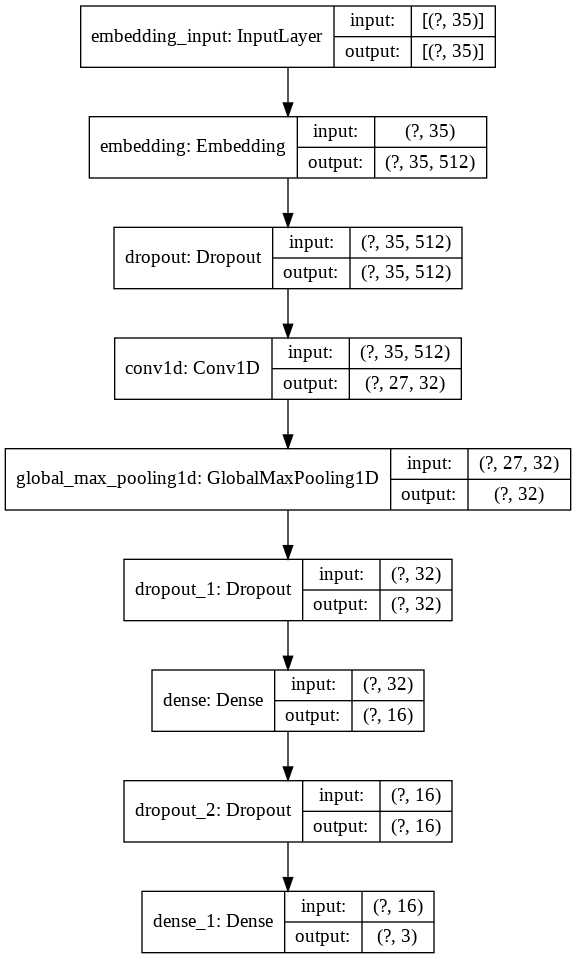

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='Taller03_1.png',show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Taller03_1.png')

Train and Evaluate

In [ ]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.Adam(lr=1e-4), loss="categorical_crossentropy", metrics=["acc"])

In [ ]:
#datos para tensorboard
direc='Ej1_model1_1'
monitor_metric='val_acc'
name=CurrentPath+'/CONV_NoTransf'

    
callbacks_list = [ tf.keras.callbacks.EarlyStopping( monitor=monitor_metric, patience=4,), # Interrumpe entrenamiento cuando no hay mejora
                  
                  # monitor -> Monitorea el accuracy de validación del modelo
                  # patience -> Interrumpe el entrenamiento cuando el accuracy no mejora apartir de una epoca
                  
                  tf.keras.callbacks.ModelCheckpoint(filepath=name+'.h5', monitor='val_acc', save_best_only=True,)]

history = model.fit(
    X_train, y_train, batch_size=32, epochs=80, validation_data=(X_test, y_test),callbacks=callbacks_list
)

Epoch 1/80
97/97 [==============================] - 19s 195ms/step - loss: 1.1015 - acc: 0.3432 - val_loss: 1.0969 - val_acc: 0.3789
Epoch 2/80
97/97 [==============================] - 20s 209ms/step - loss: 1.0940 - acc: 0.3535 - val_loss: 1.0933 - val_acc: 0.3905
Epoch 3/80
97/97 [==============================] - 20s 210ms/step - loss: 1.0939 - acc: 0.3577 - val_loss: 1.0887 - val_acc: 0.4407
Epoch 4/80
97/97 [==============================] - 20s 210ms/step - loss: 1.0845 - acc: 0.3964 - val_loss: 1.0807 - val_acc: 0.4549
Epoch 5/80
97/97 [==============================] - 20s 209ms/step - loss: 1.0776 - acc: 0.4038 - val_loss: 1.0714 - val_acc: 0.4768
Epoch 6/80
97/97 [==============================] - 20s 209ms/step - loss: 1.0649 - acc: 0.4499 - val_loss: 1.0619 - val_acc: 0.5039
Epoch 7/80
97/97 [==============================] - 20s 210ms/step - loss: 1.0513 - acc: 0.4544 - val_loss: 1.0490 - val_acc: 0.5129
Epoch 8/80
97/97 [==============================] - 20s 208ms/step - 

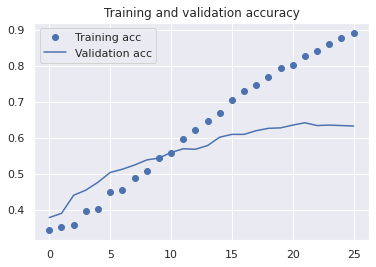

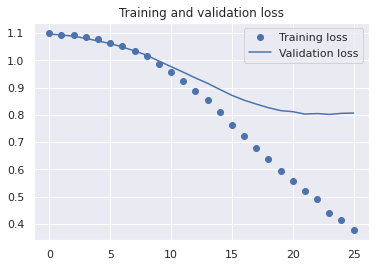

In [ ]:


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model = tf.keras.models.load_model(CurrentPath+'/CONV_NoTransf.h5') 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score,  confusion_matrix
y_test_pred=model.predict(X_test)
y_test_pred=enc_train.inverse_transform(y_test_pred)
y_test=enc_train.inverse_transform(y_test)

score=accuracy_score(y_test, y_test_pred)
print('test',score)

test 0.6417525773195877


In [ ]:

print(classification_report(labels_test, y_test_pred))

              precision    recall  f1-score   support

           N       0.65      0.74      0.69       258
         NEU       0.57      0.53      0.55       259
           P       0.70      0.66      0.68       259

    accuracy                           0.64       776
   macro avg       0.64      0.64      0.64       776
weighted avg       0.64      0.64      0.64       776



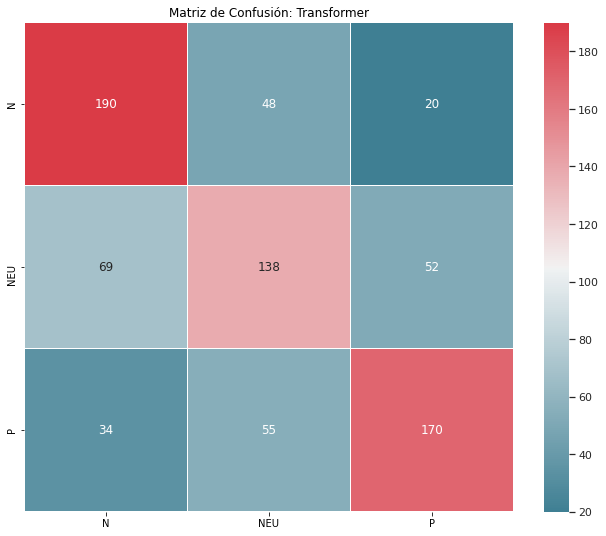

In [ ]:
import seaborn as sns

# matriz de confusion
C = confusion_matrix(y_test, y_test_pred)
df_c=pd.DataFrame(C)
df_c.columns=np.unique(y_test).tolist()
df_c.index=np.unique(y_test).tolist()
f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(df_c, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión: CNN')
plt.show()

In [ ]:
del model